In [38]:
import sys
sys.path.insert(0, "../src")

import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns

import sys
if '..' not in sys.path:
    sys.path.append('..')

from probabilistic_model import ProbabilisticModel

np.random.seed(1)

In [39]:
state_labels = {
    'hda': 0,
    'lda': 1,
    'liquid': 2,
    'ice': 2
}

def load_data(model, feat='all', size=16, states=['hda', 'lda']):
    ''' Method for efficiently loading environments for a given number of neighbors. '''
    desc_dir = '..'
    descs = []
    labels = []
    for state in states:
        if feat == 'stein':
            stein = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_stein.npy')
            descs.append(stein)
            for _ in range(stein.shape[0]):
                labels.append(state_labels[state])
        elif feat == 'all':
            acsf = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_acsf.npy')
            stein = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_stein.npy')
            desc = np.hstack((acsf, stein))
            descs.append(desc)
            for _ in range(desc.shape[0]):
                labels.append(state_labels[state])
    desc = np.vstack(descs)
    labels = np.array(labels)
    return desc, labels

def get_feature_names():
    '''Method for generating feature names for ACSFs and Steinhardt parameters.'''
    from dscribe.descriptors import ACSF
    from steinhardt import desc_to_index_mapping
    feature_names = []
    acsf = ACSF(
        species=['H', 'O'],
        periodic=False,
        r_cut=5.0,
        g2_params=[[0.5, 1.0],[1.0, 1.0],[1.5, 1.0],[2.0, 1.0],[2.5, 1.0],[3.0, 1.0],[3.5, 1.0],[4.0, 1.0],[4.5, 1.0],[5.0, 1.0]],
        g3_params=[0.5, 1.0, 1.5, 2.0],
        g4_params=[[0.0, 1.0, 1.0],[0.0, 0.5, 1.0],[2.0, 1.0, 1.0],[2.0, 0.5, 1.0],[4.5, 1.0, 1.0],[4.5, 0.5, 1.0],[0.0, 1.0, -1.0],[0.0, 0.5, -1.0],[2.0, 1.0, -1.0],[2.0, 0.5, -1.0],[4.5, 1.0, -1.0],[4.5, 0.5, -1.0]],
        g5_params=[[2.0, 1.0, 1.0],[2.0, 0.5, 1.0],[4.5, 1.0, 1.0],[4.5, 0.5, 1.0],[2.0, 1.0, -1.0],[2.0, 0.5, -1.0],[4.5, 1.0, -1.0],[4.5, 0.5, -1.0]]
    )
    for spec in ['H', 'O']:
        feature_names.append(f'G1 | {spec}')
        for param_set in acsf.g2_params:
                feature_names.append(f'G2 | {spec} | {param_set}')
        for param_set in acsf.g3_params:
            feature_names.append(f'G3 | {spec} | {param_set}')
    for spec in ['H-H', 'H-O', 'O-O']:
        for param_set in acsf.g4_params:
            feature_names.append(f'G4 | {spec} | {param_set}')
        for param_set in acsf.g5_params:
            feature_names.append(f'G5 | {spec} | {param_set}')
    for key in desc_to_index_mapping.keys():
        feature_names.append(key)
    return feature_names

In [40]:
X, y = load_data(model='mbpol', feat='all', size=16, states=['hda', 'lda'])
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)
model = ProbabilisticModel(
    max_features=5, 
    include=0.98,
    detect_outliers=False,
    corr_cut=0.8,
)
model.fit(X, y)
print(f'Chosen features: {model.chosen_features}')
feature_names = get_feature_names()
for i, idx in enumerate(model.chosen_features):
    print(feature_names[idx], model.mutual_information[i])

Chosen features: [0, 109, 90, 91, 108]
G1 | H 0.6573005672672926
av_q12 0.46744687314875744
q3 0.40640412657783725
q4 0.3833807497436256
av_q11 0.32979258335677936


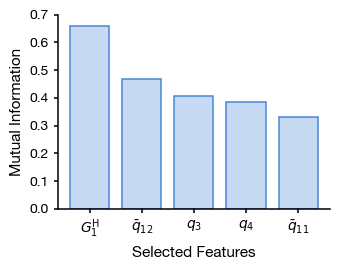

In [62]:
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.1
fig, ax = plt.subplots(1,1,figsize=(3.5,2.8))
labels = [
    r'$G_1^{\text{H}}$',
    r'$\bar{q}_{12}$',
    r'$q_{3}$',
    r'$q_{4}$',
    r'$\bar{q}_{11}$'
]
y = [model.mutual_information[i] for i in range(len(model.chosen_features))]
ax.bar([i for i in range(len(y))], y, width=0.75, linewidth=1.1, edgecolor="#4A86D4", color="#C6DAF3")
ax.set_xticks(ticks=[i for i in range(len(y))], labels=labels)
ax.set_yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax.tick_params(axis='both', left=True, bottom=True, width=1.1, length=3.0)
ax.set_ylabel('Mutual Information', size=11)
ax.set_xlabel('Selected Features', size=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('./figures/feat_importance.pdf', dpi=1000)
plt.show()

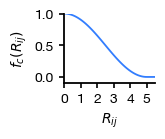

In [70]:
# Visualize the first considered function.
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))

# Compute the first ACSF.
x = np.linspace(0.0, 5.5)
y = 0.5 * (np.cos((np.pi * x) / 5) + 1)
x_cut = np.argwhere(x > 5.0).reshape(-1)
y[x_cut] = 0.0

# Plot.
ax.plot(x, y, color="#327DFE", linewidth=1.3)
ax.set_xlim(xmin=0.0, xmax=5.5)
ax.set_ylim(ymin=-0.1, ymax=1.0)
ax.set_xlabel(r'$R_{ij}$')
ax.set_ylabel(r'$f_{c}(R_{ij})$')
ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5])
ax.set_yticks(ticks=[0.0, 0.5, 1.0])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/acsf_1.svg', dpi=1000, transparent=True)
plt.show()

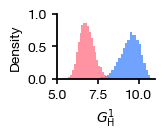

In [76]:
# Visualize the first considered function.
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))

# Compute the first ACSF.
hda_dist = X[hda_idx,0]
lda_dist = X[lda_idx,0]
ax.hist(hda_dist, bins=30, density=True, color='#327DFE', alpha=0.7)
ax.hist(lda_dist, bins=30, density=True, color='#FF667B', alpha=0.7)

ax.set_xlabel(r'$G^{1}_{\text{H}}$')
ax.set_ylabel('Density')
ax.set_xlim(xmin=5.0, xmax=11.0)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_xticks(ticks=[5.0, 7.5, 10.0])
ax.set_yticks(ticks=[0.0, 0.5, 1.0])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/acsf_1_dist.svg', dpi=1000, transparent=True)
plt.show()

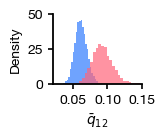

In [82]:
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))
hda_dist = X[hda_idx,109]
lda_dist = X[lda_idx,109]
ax.hist(hda_dist, bins=30, density=True, color='#327DFE', alpha=0.7)
ax.hist(lda_dist, bins=30, density=True, color='#FF667B', alpha=0.7)
ax.set_xlabel(r'$\bar{q}_{12}$')
ax.set_ylabel('Density')
ax.set_xlim(xmin=0.02, xmax=0.15)
ax.set_ylim(ymin=0.0, ymax=50)
ax.set_xticks(ticks=[0.05, 0.10, 0.15])
ax.set_yticks(ticks=[0, 25, 50])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('./figures/acsf_2_dist.svg', dpi=1000, transparent=True)
plt.show()

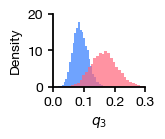

In [88]:
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))
hda_dist = X[hda_idx,90]
lda_dist = X[lda_idx,90]
ax.hist(hda_dist, bins=30, density=True, color='#327DFE', alpha=0.7)
ax.hist(lda_dist, bins=30, density=True, color='#FF667B', alpha=0.7)
ax.set_xlabel(r'$q_{3}$')
ax.set_ylabel('Density')
ax.set_xlim(xmin=0.0, xmax=0.30)
ax.set_ylim(ymin=0.0, ymax=20)
ax.set_xticks(ticks=[0.0, 0.1, 0.2, 0.3])
ax.set_yticks(ticks=[0, 10, 20])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('./figures/acsf_3_dist.svg', dpi=1000, transparent=True)
plt.show()

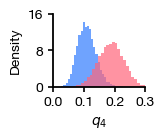

In [93]:
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))
hda_dist = X[hda_idx,91]
lda_dist = X[lda_idx,91]
ax.hist(hda_dist, bins=30, density=True, color='#327DFE', alpha=0.7)
ax.hist(lda_dist, bins=30, density=True, color='#FF667B', alpha=0.7)
ax.set_xlabel(r'$q_{4}$')
ax.set_ylabel('Density')
ax.set_xlim(xmin=0.0, xmax=0.30)
ax.set_ylim(ymin=0.0, ymax=16)
ax.set_xticks(ticks=[0.0, 0.1, 0.2, 0.3])
ax.set_yticks(ticks=[0, 8, 16])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('./figures/acsf_4_dist.svg', dpi=1000, transparent=True)
plt.show()

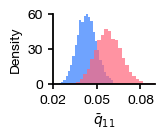

In [101]:
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))
hda_dist = X[hda_idx,108]
lda_dist = X[lda_idx,108]
ax.hist(hda_dist, bins=30, density=True, color='#327DFE', alpha=0.7)
ax.hist(lda_dist, bins=30, density=True, color='#FF667B', alpha=0.7)
ax.set_xlabel(r'$\bar{q}_{11}$')
ax.set_ylabel('Density')
ax.set_xlim(xmin=0.02, xmax=0.09)
ax.set_ylim(ymin=0.0, ymax=60)
ax.set_xticks(ticks=[0.02, 0.05, 0.08])
ax.set_yticks(ticks=[0, 30, 60])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('./figures/acsf_5_dist.svg', dpi=1000, transparent=True)
plt.show()

In [ ]:
###
# Analyze correlation between identified features and tetrahedrality.
###

def compute_tetrahedrality(frame):
    '''Computes the tetrahedral order parameter for a single environment.'''
    oxy_idx = np.argwhere(frame[:,0] == 1).reshape(-1)
    frame = frame[oxy_idx,1:]
    dist = np.linalg.norm(frame, axis=1)
    sorted_idx = np.argsort(dist).reshape(-1)
    frame = frame[sorted_idx[0:5]] 
    pairs = [[1,2], [1,3], [1,4], [2,3], [2,4], [3,4]]
    sum = 0.0
    for (i,j) in pairs:
        a = frame[i]
        b = frame[j]
        cos_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        sum += (cos_angle + 1. / 3.) ** 2
    q = 1.0 - (3. / 8.) * sum
    return q

In [114]:
hda_coords = np.load('../data/descriptors/neigh_16/mbpol_hda_coords.npy')
lda_coords = np.load('../data/descriptors/neigh_16/mbpol_lda_coords.npy')
hda_q = np.array([compute_tetrahedrality(hda_coords[idx]) for idx in range(hda_coords.shape[0])])
lda_q = np.array([compute_tetrahedrality(lda_coords[idx]) for idx in range(lda_coords.shape[0])])

In [115]:
X_hda = np.hstack((
    np.load('../data/descriptors/neigh_16/mbpol_hda_acsf.npy'),
    np.load('../data/descriptors/neigh_16/mbpol_hda_stein.npy')
))
X_lda = np.hstack((
    np.load('../data/descriptors/neigh_16/mbpol_lda_acsf.npy'),
    np.load('../data/descriptors/neigh_16/mbpol_lda_stein.npy')
))

Correlation for HDA, Feat #0: -0.15428350387425768
Correlation for HDA, Feat #1: -0.03253860422577651
Correlation for HDA, Feat #2: 0.02488159121089056
Correlation for HDA, Feat #3: 0.0890957978442944
Correlation for HDA, Feat #4: 0.00804945912868778
Correlation for LDA, Feat #0: -0.23667525319198288
Correlation for LDA, Feat #1: 0.21666926338059267
Correlation for LDA, Feat #2: 0.2686121874481803
Correlation for LDA, Feat #3: 0.013462106306822994
Correlation for LDA, Feat #4: 0.02205312146932513
Correlation for both, Feat #0: -0.6296560689578072
Correlation for both, Feat #1: 0.5654581399177279
Correlation for both, Feat #2: 0.5689950441435481
Correlation for both, Feat #3: 0.5094369423029438
Correlation for both, Feat #4: 0.47299249991759285


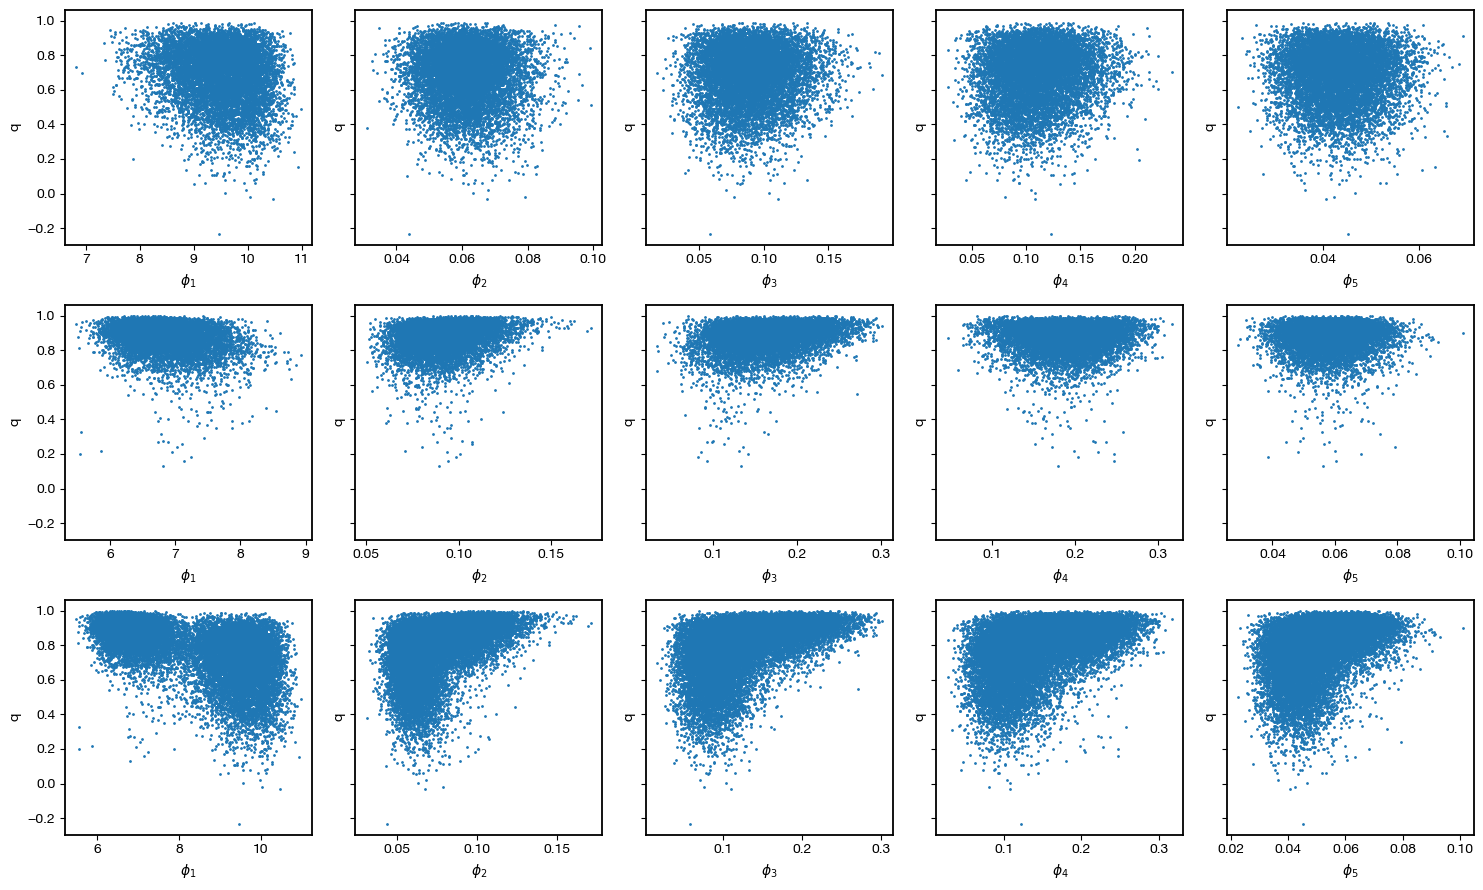

In [125]:
from scipy.stats import pearsonr, spearmanr
chosen_feat = [0, 109, 90, 91, 108]
# chosen_feat = [105, 106, 107, 108, 109]

fig, axs = plt.subplots(3,len(chosen_feat),figsize=(15,9), sharey=True)

# Plot for HDA environments.
for feat_idx, feat in enumerate(chosen_feat):
    print(f'Correlation for HDA, Feat #{feat_idx}: {spearmanr(X_hda[:,feat], hda_q).statistic}')
    axs[0,feat_idx].scatter(X_hda[:,feat], hda_q, s=1.0)
    axs[0,feat_idx].set_ylabel('q')
    axs[0,feat_idx].set_xlabel(rf'$\phi_{feat_idx + 1}$')

# Plot for LDA environments.
for feat_idx, feat in enumerate(chosen_feat):
    print(f'Correlation for LDA, Feat #{feat_idx}: {spearmanr(X_lda[:,feat], lda_q).statistic}')
    axs[1,feat_idx].scatter(X_lda[:,feat], lda_q, s=1.0)
    axs[1,feat_idx].set_ylabel('q')
    axs[1,feat_idx].set_xlabel(rf'$\phi_{feat_idx + 1}$')

# Plot for everything.
for feat_idx, feat in enumerate(chosen_feat):
    X_temp = np.vstack((X_hda, X_lda))
    q_temp = np.hstack((hda_q, lda_q))
    print(f'Correlation for both, Feat #{feat_idx}: {spearmanr(X_temp[:,feat], q_temp).statistic}')
    axs[2,feat_idx].scatter(X_temp[:,feat], q_temp, s=1.0)
    axs[2,feat_idx].set_ylabel('q')
    axs[2,feat_idx].set_xlabel(rf'$\phi_{feat_idx + 1}$')

plt.tight_layout()
plt.show()